In [ ]:
!pip install transformers[sentencepiece] datasets rouge_score py7zr -q

In [ ]:
!pip install evaluate

In [ ]:
from transformers import pipeline, set_seed
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import evaluate
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import nltk
from nltk.tokenize import sent_tokenize
nltk.download ('punkt')
from transformers import pipeline, set_seed
from datasets import load_metric

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/preprocessed_data.parquet')

In [ ]:
df.iloc[1]

,1
article,reactive oxygen species cytokines considered i...
abstract,pancreatic cancer is one of the most aggressiv...


In [ ]:
set_seed(42)
sample_text = df.iloc[1]['article'][:1000]
summaries = {}

In [ ]:
def baseline_summary_three_sent(text):
  return "\n".join(sent_tokenize(text)[:3])

In [ ]:
summaries['baseline'] = baseline_summary_three_sent(sample_text)
summaries['baseline']

'reactive oxygen species cytokines considered important factors pathogenesis pancreatic cancer one two source ros nicotinamide adenine dinucleotide phosphate oxidase involved pancreatic cancer development three ros activate signaling pathways mediated mitogen activated protein kinases nf janus kinase signal transducer activator transcription forty eight inhibits cancer cell apoptosis induces cytokine expression epithelial mesenchymal transition ten eleven high levels fibronectin laminin ten eleven cytokines fourteen observed pancreatic cancer growth factors fourteen extracellular matrix proteins ten cytokines one thousand four hundred seventeen shown activate nox pathogenesis pancreatic cancer development bioactive compounds curcumin genistein resveratrol antioxidant antitumor activities pancreatic cancer briefly review role ros cytokines pathogenesis pancreatic cancer addition bioactive compounds may prevent development pancreatic cancer also discussed since ros pro inflammatory cytok

# **GPT-2**

In [ ]:
pipe = pipeline("text-generation", model="gpt2-medium")
gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
pipe_out

[{'generated_text': "reactive oxygen species cytokines considered important factors pathogenesis pancreatic cancer one two source ros nicotinamide adenine dinucleotide phosphate oxidase involved pancreatic cancer development three ros activate signaling pathways mediated mitogen activated protein kinases nf janus kinase signal transducer activator transcription forty eight inhibits cancer cell apoptosis induces cytokine expression epithelial mesenchymal transition ten eleven high levels fibronectin laminin ten eleven cytokines fourteen observed pancreatic cancer growth factors fourteen extracellular matrix proteins ten cytokines one thousand four hundred seventeen shown activate nox pathogenesis pancreatic cancer development bioactive compounds curcumin genistein resveratrol antioxidant antitumor activities pancreatic cancer briefly review role ros cytokines pathogenesis pancreatic cancer addition bioactive compounds may prevent development pancreatic cancer also discussed since ros pr

In [ ]:
# Extract desired text (adjust slicing/indexing as needed)
#generated_text = pipe_out[0]['generated_text'][len(gpt2_query):]

In [ ]:
# Tokenize sentences
#summaries['gpt2'] = "\n".join(sent_tokenize(generated_text))
summaries['gpt2'] = "\n".join(sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query):]))

# **T5**

In [ ]:
pipe = pipeline("summarization", model="t5-small")
pipe_out = pipe(sample_text)

In [ ]:
pipe_out

[{'summary_text': 'ros nicotinamide adenine dinucleotide phosphate oxidase involved pancreatic cancer development three ros activate signaling pathways mediated mitogen activated protein kinases nf janus kine transducer activator transcription forty eight inhibits cancer cell apoptosis induces cytokine expression epithelial mesenchymal transition ten 11 high levels fibronectin laminin ten eleven cytokines'}]

In [ ]:
summaries['t5'] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))

# **BART**

In [ ]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)

In [ ]:
pipe_out

[{'summary_text': 'Pancreatic cancer briefly review role ros cytokines pathogenesis. bioactive compounds curcumin genistein resveratrol antioxidant antitumor activities. reactive oxygen species cytokines considered important factors pathogenesis pancreatic cancer one two source ros nicotinamide adenine dinucleotide phosphate oxidase involved pancreatic Cancer development.'}]

In [ ]:
summaries['bart'] = "\n".join(sent_tokenize(pipe_out[0]['summary_text']))

In [ ]:
print('Ground Truth')
print(df.iloc[1]['abstract'])

for model_name in summaries:
  print(model_name.upper())
  print(summaries[model_name])

Ground Truth
pancreatic cancer is one of the most aggressive drug resistant and lethal types of cancer with poor prognosis various factors including reactive oxygen species cytokines growth factors and extracellular matrix proteins are reported to be involved in the development of pancreatic cancer however the pathogenesis of pancreatic cancer has not been completely elucidated oxidative stress has been shown to contribute to the development of pancreatic cancer evidences supporting the role of reactive oxygen species and cytokines as risk for pancreatic cancer and the concept of antioxidant supplementation as preventive approach for pancreatic cancer have been proposed here we review the literature on oxidative stress cytokine expression inflammatory signaling and natural antioxidant supplementation in relation to pancreatic cancer
BASELINE
reactive oxygen species cytokines considered important factors pathogenesis pancreatic cancer one two source ros nicotinamide adenine dinucleotide

In [ ]:
rouge_metric = load_metric('rouge')

<ipython-input-20-90542a62301a>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric('rouge')


In [ ]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

In [ ]:
reference = df.iloc[1]['abstract']

records = []

for model_name in summaries:
  rouge_metric.add(prediction=summaries[model_name], reference=reference)
  score = rouge_metric.compute()
  rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
  print('rouge_dict', rouge_dict)
  records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())

rouge_dict {'rouge1': 0.3319148936170213, 'rouge2': 0.12017167381974249, 'rougeL': 0.19574468085106383, 'rougeLsum': 0.19574468085106383}
rouge_dict {'rouge1': 0.3206997084548105, 'rouge2': 0.05865102639296187, 'rougeL': 0.14577259475218662, 'rougeLsum': 0.22157434402332363}
rouge_dict {'rouge1': 0.10975609756097561, 'rouge2': 0.024691358024691357, 'rougeL': 0.08536585365853658, 'rougeLsum': 0.08536585365853658}
rouge_dict {'rouge1': 0.24358974358974358, 'rouge2': 0.07792207792207792, 'rougeL': 0.15384615384615385, 'rougeLsum': 0.1794871794871795}


,rouge1,rouge2,rougeL,rougeLsum
baseline,0.331915,0.120172,0.195745,0.195745
gpt2,0.320700,0.058651,0.145773,0.221574
t5,0.109756,0.024691,0.085366,0.085366
bart,0.243590,0.077922,0.153846,0.179487


In [ ]:
# Ensure there are only 10 articles
data = df.iloc[:500]

# Set the seed for reproducibility
set_seed(42)

# Initialize the GPT-2 pipeline
pipe = pipeline("text-generation", model="gpt2-medium")

# Define a function to generate baseline summary (first 3 sentences)
def baseline_summary_three_sent(text):
    return "\n".join(sent_tokenize(text)[:3])

# Initialize an empty dictionary to store summaries
summaries = {}

# Iterate over the articles in the dataset
for i in range(len(data)):
    # Extract the article text (limited to the first 1000 characters)
    sample_text = data.iloc[i]['article'][:1000]

    # Generate the baseline summary
    summaries[f'baseline_{i}'] = baseline_summary_three_sent(sample_text)

    # Prepare the query for GPT-2
    gpt2_query = sample_text + "\nTL;DR:\n"

    # Generate the summary using GPT-2
    pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True, truncation=True)

    # Store the GPT-2 generated summary, trimming the "TL;DR:" part
    summaries[f'gpt2_{i}'] = "\n".join(sent_tokenize(pipe_out[0]['generated_text'][len(gpt2_query):]))

# Print all the summaries along with the ground truth abstracts
for i in range(len(data)):
    print(f'Article {i+1} Ground Truth')
    print(data.iloc[i]['abstract'])
    print()
    print(f'BASELINE SUMMARY {i+1}')
    print(summaries[f'baseline_{i}'])
    print()
    print(f'GPT-2 SUMMARY {i+1}')
    print(summaries[f'gpt2_{i}'])
    print('-' * 80)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


KeyboardInterrupt: 

In [ ]:
"""records = []

for model_name in summaries:
  rouge_metric.add(prediction=summaries[model_name], reference=reference)
  score = rouge_metric.compute()
  rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
  print('rouge_dict', rouge_dict)
  records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())"""

In [ ]:
# Store the results in a dictionary
records = []

# Loop through each summary (both baseline and GPT-2) and calculate ROUGE scores
for i in range(len(data)):
    reference = data.iloc[i]['abstract']

    # Compute ROUGE scores for baseline summary
    rouge_metric.add(prediction=summaries[f'baseline_{i}'], reference=reference)
    baseline_score = rouge_metric.compute()
    baseline_rouge_dict = dict((rn, baseline_score[rn].mid.fmeasure) for rn in rouge_names)

    # Compute ROUGE scores for GPT-2 generated summary
    rouge_metric.add(prediction=summaries[f'gpt2_{i}'], reference=reference)
    gpt2_score = rouge_metric.compute()
    gpt2_rouge_dict = dict((rn, gpt2_score[rn].mid.fmeasure) for rn in rouge_names)

    # Store the scores in the records list
    records.append({
        'article_index': i + 1,
        'baseline_rouge1': baseline_rouge_dict['rouge1'],
        'baseline_rouge2': baseline_rouge_dict['rouge2'],
        'baseline_rougeL': baseline_rouge_dict['rougeL'],
        'gpt2_rouge1': gpt2_rouge_dict['rouge1'],
        'gpt2_rouge2': gpt2_rouge_dict['rouge2'],
        'gpt2_rougeL': gpt2_rouge_dict['rougeL'],
    })

# Convert the records to a DataFrame
results_df = pd.DataFrame.from_records(records)

# Display the results DataFrame
print(results_df)

   article_index  baseline_rouge1  baseline_rouge2  baseline_rougeL  \
0              1         0.211480         0.085106         0.132931   
1              2         0.331915         0.120172         0.195745   
2              3         0.088889         0.000000         0.044444   
3              4         0.181818         0.025000         0.099174   
4              5         0.278746         0.098246         0.174216   
5              6         0.313725         0.108911         0.264706   
6              7         0.161850         0.070175         0.127168   
7              8         0.191011         0.062147         0.089888   
8              9         0.254717         0.028571         0.150943   
9             10         0.240741         0.086957         0.117284   

   gpt2_rouge1  gpt2_rouge2  gpt2_rougeL  
0     0.114286     0.000000     0.073469  
1     0.338462     0.103093     0.194872  
2     0.124661     0.010899     0.075881  
3     0.263027     0.019950     0.109181  
4  

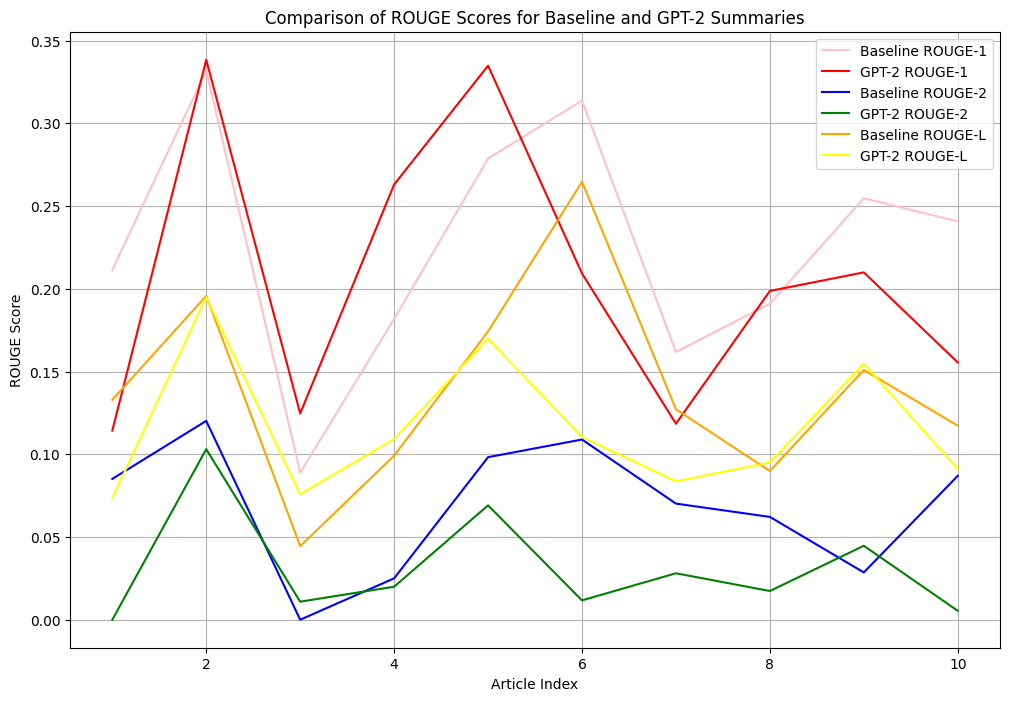

In [ ]:
# Plot the ROUGE scores for each article
plt.figure(figsize=(12, 8))

# Plot for ROUGE-1
plt.plot(results_df['article_index'], results_df['baseline_rouge1'], label='Baseline ROUGE-1', color='pink')
plt.plot(results_df['article_index'], results_df['gpt2_rouge1'], label='GPT-2 ROUGE-1', color='red')

# Plot for ROUGE-2
plt.plot(results_df['article_index'], results_df['baseline_rouge2'], label='Baseline ROUGE-2', color='blue')
plt.plot(results_df['article_index'], results_df['gpt2_rouge2'], label='GPT-2 ROUGE-2', color='green')

# Plot for ROUGE-L
plt.plot(results_df['article_index'], results_df['baseline_rougeL'], label='Baseline ROUGE-L', color='orange')
plt.plot(results_df['article_index'], results_df['gpt2_rougeL'], label='GPT-2 ROUGE-L', color='yellow')

plt.title('Comparison of ROUGE Scores for Baseline and GPT-2 Summaries')
plt.xlabel('Article Index')
plt.ylabel('ROUGE Score')
plt.legend()
plt.grid(True)
plt.show()

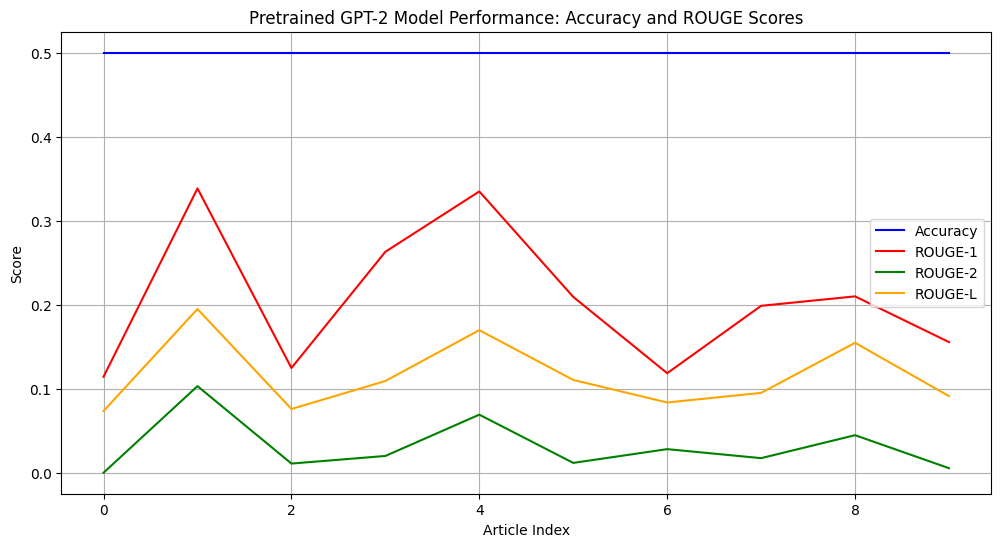

In [ ]:
# Assuming you have the following lists filled with scores
# These lists should contain the ROUGE scores for each article
gpt2_rouge1_scores = [score for score in results_df['gpt2_rouge1']]
gpt2_rouge2_scores = [score for score in results_df['gpt2_rouge2']]
gpt2_rougeL_scores = [score for score in results_df['gpt2_rougeL']]
# You can create a dummy accuracy score list if you want to include it
# If you don't have accuracy data, you can skip this
gpt2_accuracy_scores = [0.5] * len(gpt2_rouge1_scores)  # Example dummy accuracy scores

# Plot the scores
plt.figure(figsize=(12, 6))

# Plot the accuracy scores if available
plt.plot(gpt2_accuracy_scores, label='Accuracy', color='blue')

# Plot ROUGE-1 scores
plt.plot(gpt2_rouge1_scores, label='ROUGE-1', color='red')

# Plot ROUGE-2 scores
plt.plot(gpt2_rouge2_scores, label='ROUGE-2', color='green')

# Plot ROUGE-L scores
plt.plot(gpt2_rougeL_scores, label='ROUGE-L', color='orange')

# Set plot titles and labels
plt.title('Pretrained GPT-2 Model Performance: Accuracy and ROUGE Scores')
plt.xlabel('Article Index')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()